<p style="text-align:right;">Mario Stanke, University of Greifswald, Germany</p>

# Solutions to Exercise Set 1, Exercise 3 -  SGD Parameters

Play with the parameters of the stochastic gradient descent algorithm.
 1. Execute the notebook with the high-level method from this morning's lecture as is (Kernel -> Restart & Run All).
 2. Jump to **Exercise** after the heading "Solution 2" and do as told there.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [2]:
# load the training data from the table file to a pandas data frame
df = pd.read_csv("bikes-summerdays.tbl", sep='\s+')

# convert count data to floats as regression target
df['count'] = df['count'].astype(float) 

m, n_cols = df.shape # training set size and number of columns 
print("m = ", m, "\tn_cols = ", n_cols)

# compute average of hourly bike rental counts
meancount = np.mean(df['count'])

m =  1482 	n_cols =  2


## Create Data Matrix $X$ and response vector $y$

In [3]:
# extract response vector
y_train = np.array(df['count']) 

# extract feature columns
n = n_cols - 1 # number of features
temps = np.array(df.loc[:, df.columns != 'count']) # matrix of all other columns (here only one col)

# make data matrix X
X_train = np.ones((m, n+1)) # initialize with all ones
# overwrite all but the zero-th column with features
X_train[:,1:n+1] = temps / 10 - 2.5 # normalize temperatures so they are roughly in [-1,1] 

## Define Loss Function

In [4]:
# mean squared error loss function
def MSE(theta):
    """
        Mean squared error function for linear regression
        theta: numpy array of parameters, the first dimension must match the number of cols of X
               If theta is 2-dimensional, the output is 1-dim with one entry per col of theta.
    """
    if len(theta.shape) == 1: # theta is 1-dimensional
        theta = tf.reshape(theta, (-1, 1)) # make it a matrix with one column
    # now theta is a matrix in any case
    yhat = tf.linalg.matmul(X_train, theta) # vector of predicted rental counts
    d = (yhat - y_train.reshape((-1, 1)))**2 # square the residuals ('errors')
    E = tf.reduce_sum(d, axis=0) / m
    return E

In [5]:
# two tests of calls to error function
print("single point:", MSE(np.array([1., 2.])))
print("two points: ", MSE(np.array([[1., 3.], [2., 4.]])))

single point: tf.Tensor([126566.30681717], shape=(1,), dtype=float64)
two points:  tf.Tensor([126566.30681717 125266.24137933], shape=(2,), dtype=float64)


In [6]:
# this is for lecture purposes only and NEED NOT BE READ
def contourPlot():
    ''' Plot the error landscape'''
    # compute error for the grid of all combinations of theta0 and theta1 values
    theta0 = theta1 = np.arange(-3200., 3200., 100) # grid axis ranges
    xv, yv = np.meshgrid(theta0, theta1) # x and y values of all grid points
    Theta = np.array([xv, yv]).reshape(2, -1) # 2 rows, one col per grid point

    # compute error for all grid points
    z = MSE(Theta).numpy()
    z = z.reshape((theta0.size, -1)) # make this a matrix again as required by contour

    ## make contour plot
    _, axC = plt.subplots()
    # heights to draw contour lines for
    h = [50000, 200000] + list(range(500000, 6000001, 500000))
    contours = axC.contour(theta0, theta1, z, levels=h, colors='black')
    axC.clabel(contours, inline=True, fontsize=8, fmt='%i') # labels on lines
    plt.title("mean squared error " + r'$E(\theta)$');
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$');
    return axC


## Visualization of optimization progress

In [7]:
def plot_error(err, col):
    ''' Plot error over time'''
    plt.subplots()
    plt.plot(np.log(err), 'o-', color=col, linewidth=.2, markersize=3, mfc='none')
    plt.title("Log error by iteration of gradient descent")
    plt.xlabel('iteration '+r'$i$')
    plt.ylabel(r'$ln \;E(\theta^{(i)})$');

def plot_progress(Theta, err, col, ):
    '''Plot error and parameters over time'''
    plot_error(err, col)
    # enter parameter trajectory to above contour plot
    axC = contourPlot()
    plt.plot(Theta[0, 0], Theta[1, 0], 'o', color='green', mfc='none') # mark starting point with circle
    ymin, ymax = axC.get_ylim()
    xmin, xmax = axC.get_xlim()
    for i in range(1, Theta.shape[1]):
        if (np.abs(Theta[0, i] - Theta[0, i-1]) + np.abs(Theta[1, i] - Theta[1, i-1]) > 1e-6):
            # above condition avoids arrows with a length of 0 pixels
            plt.arrow(Theta[0, i-1], Theta[1, i-1], Theta[0, i] - Theta[0, i-1], Theta[1, i] - Theta[1, i-1],
                      color=col, width=3, head_length=20, head_width=50, overhang=.9, length_includes_head=True)

## Solution 2: high-level approach

**Exercise:**  
  1. Play with the *learning rate* $\alpha$. Find a *small* value and a *large* value so that **convergence is not reached**.
  2. Play with the *momentum* $\mu$. Find a *small* value and a *large* value so that **convergence is not reached**.
  3. Play with ```batch_size```. Find a *small* value so training is significantly **slower** and a *large* value so **convergence is not reached**.
  
When you vary one parameter, leave the other parameters as they were originally.

#### Classic Option 1: Use the **keyboard**
to edit the values in below cell, then **Run -> Run Selected Cell and Below**

In [8]:
# CHANGE THIS CODE HERE for Option 1. If you choose Option 2, leave these values as defaults (0.01, 0.8 and 32, respectively)
alpha = 0.01    # Solution: 0.001 and 2
mu = 0.8        # Solution: 0.0 and 0.99
batch_size = 32 # Solution: 2 and 200

#### Comfortable Option 2: Use the **mouse**
Execute the next two cells, use the sliders to adjust the values, then run the rest of the cells.  
*Tip:* **Create New View for Output** by right-clicking on the blue bar left of the graphs. Then drag the output window to a comfy place.

In [9]:
import ipywidgets as widgets
style = {'description_width': 'initial'}
layout = widgets.Layout(width = '100%')
alpha_slider = widgets.FloatLogSlider(value = alpha, min = -4, max = 1, step = 0.001,
    description = 'learning rate ' + r'$\alpha$:', readout_format = '.4f',
    style = style, layout = layout)
mu_slider = widgets.FloatSlider(value = mu, min = 0, max = 1.0, step = 0.02,
    description = 'momentum ' + r'$\mu$:', readout_format = '.2f',
    style = style, layout = layout)
batch_slider = widgets.IntSlider(value = batch_size, min = 1, max = m, step = 1,
                                 description = 'batch size:', style = style, layout = layout)

In [10]:
display(alpha_slider)
display(mu_slider)
display(batch_slider)

FloatLogSlider(value=0.01, description='learning rate $\\alpha$:', layout=Layout(width='100%'), max=1.0, min=-…

FloatSlider(value=0.8, description='momentum $\\mu$:', layout=Layout(width='100%'), max=1.0, step=0.02, style=…

IntSlider(value=32, description='batch size:', layout=Layout(width='100%'), max=1482, min=1, style=SliderStyle…

In [11]:
alpha = alpha_slider.value
mu = mu_slider.value
batch_size = batch_slider.value

In [12]:
print ("Used values alpha =", alpha, ", mu =", mu, ", batch_size =", batch_size)

Used values alpha = 0.01 , mu = 0.8 , batch_size = 32


In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate = alpha, momentum = mu)
# SGD: stochastic gradient descent

loss_object = tf.keras.losses.MeanSquaredError()
# This common and preimplemented loss implements the MSE function defined in equation (1).

### Stochastic Gradient Descent
- Heuristics for minimizing some error or loss function $E(\pmb{\theta}; ({\bf X},{\bf y}))$ with respect to $\pmb{\theta}$ more efficiently than with regular gradient descent (Formula (2)), in particular for large training data sets $({\bf X},{\bf y})$.
- Also iteratively updates parameters $\pmb{\theta}$ on the basis of the gradient $\nabla E$, but the gradient is computed only for a (small) sample $(Xbatch, Ybatch)$ of the training data. The number of examples in the batch are called the **batch size**.
- The **learning rate** $\alpha$ plays a similar role as in regular gradient descent: The larger $\alpha$, the larger the changes to $\pmb{\theta}$ in each step.
- $0\le \mu \le 1$ is called **momentum**. If $\mu = 0$, the update step is like in regular gradient descent, except that the gradient is computed on a batch only. With increasing $\mu$ the update steps are larger and fluctuate less.
 > ${\bf v} \leftarrow {\bf 0}$  
 > While the termination condition is not satisfied
 >> Sample a random batch $(\text{Xbatch},\text{Ybatch})$ from the training data $({\bf X},{\bf y})$.  
 >> ${\bf v} \leftarrow \mu \cdot {\bf v} - \alpha \cdot \nabla E(\pmb{\theta};\text{Xbatch},\text{Ybatch})$  
 >> $\pmb{\theta} \leftarrow \pmb{\theta} + {\bf v}$ 
  
- The termination condition could be
   1. A fixed number of iterations has been done.
   2. The accuracy/error on a separate validation set satisfies some condition (e.g. it is plateauing).
   3. User interruption.
- Usually, the random choices of batches are such that the number of times each example appeared in a batch differs at most by 1, i.e. the batch is drawn from the subset of examples used hitherto one less than the maximum. Once all examples have been used once, an **epoch** ends.
- Documentation and code of [tf.keras.optimizers.SGD](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers/SGD)
  

In [14]:
np.random.seed(1) # make it reproducible
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# A tf.data.Dataset has commonly used functions for random sampling, obtaining subsets, transformations
# iterating over large numbers of images on disk (using TFRecord).

dataset = dataset.shuffle(m).batch(batch_size) # random order, use whole dataset as 'batch' for comparability

In [15]:
# Get a predefined linear model with one single output variable (unit) and one weight per input.
theta_init = np.array([2000., 3000.])
model = tf.keras.Sequential()
model = tf.keras.layers.Dense(
    units = 1, input_dim = 2,
    use_bias = False, # bias equivalent to adding x_0 := 1
    kernel_initializer = tf.initializers.Constant(theta_init), # default would be random initialization
    dtype = 'float64')

In [16]:
# one gradient descent step
def train_step(x, y):
    with tf.GradientTape() as tape:
        t = model(x) # predicted rental demand
        t = tf.reshape(t, [-1])
        E = loss_object(y, t)
    grads = tape.gradient(E, model.trainable_variables)
    # this makes a parameter update using the gradient
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return E

In [17]:
N = 5
total_batches = N * math.ceil(m / batch_size)
Theta3 = np.zeros((2, total_batches)) # sequence of parameters after each step
err3 = np.zeros((total_batches)) # high-level approach error after each update step
i = 0 # batch number

for epoch in range(N):
    # loop over batches of dataset
    # Here it is here just a single big batch for comparability with Solution 1.
    for (x, y) in dataset:
        # x: batch features of shape (batch_size, 2)
        # y: batch labels
        E = train_step(x, y)
        Theta3[:, [i]] = model.get_weights()[0]
        err3[i] = E
        i = i + 1

In [18]:
# Below line makes the plot interactive (zooming enabled) if uncommented but
# works on jupyterhub.brain only for classic notebooks (Help -> Launch Classic Notebook).
# %matplotlib notebook

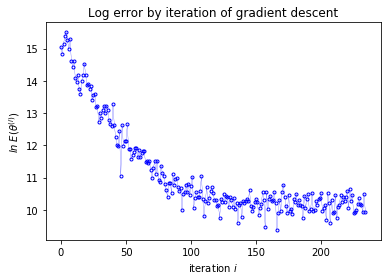

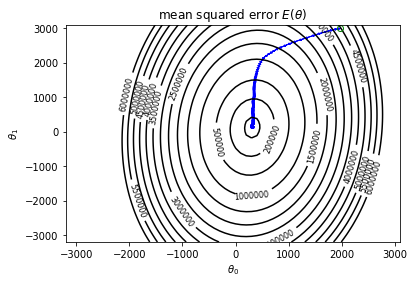

In [19]:
plot_progress(Theta3, err3, col = 'blue');

**Remarks:**
  - In above plot of training error, the errors were measured only on a batch and are thus estimates of the training error only.
  - When using stochastic gradient descent, typically the parameter trajectory eventually random walks near a local optimum and their latest values may result in a larger loss than some parameter value previously attained.

In [20]:
# final loss and prediction computed on all training data
pred = model(X_train)
pred = tf.reshape(pred, [m])
E = loss_object(y_train, pred)
print("final error = ", E.numpy())
print("theta:\n", model.trainable_variables[0].numpy())

final error =  27258.09375
theta:
 [[321.14703373]
 [119.56404593]]
